# Machine Learning Project: Key Detection
Authors: Zach Hayes, Matt Gaetano, Max Ivry

Course: CS3540


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

from imblearn.over_sampling import SMOTE

from keras.api.utils import to_categorical
from keras.api.models import Sequential
from keras.api.layers import Dense, Flatten, Dropout, Input, Conv2D, MaxPooling2D
from keras.api.regularizers import L2
from keras.api.callbacks import EarlyStopping
from keras.api import optimizers

### Gather Training and Testing Data
Data cleaning and feature extraction occured earlier in process. See clean.ipynb

In [9]:
def retrieve_data(square_data = False):
    train_df = pd.read_json("train.json", lines=True)

    def combine_equal(df):
        # Combine "tonally equivalent" classes by replacing some labels
        tonal_equ = {
                "A#": "Bb",
                "B#": "C",
                "C#": "Db",
                "D#": "Eb",
                "E#": "F",
                "F#": "Gb",
                "G#": "Ab"
            }
    
        df[['note', 'modality']] = pd.DataFrame(df.target.tolist(), index=df.index)
        df["note"] = df['note'].replace(tonal_equ)
        df["target"] = df[["note", "modality"]].astype(str).apply(' '.join, axis=1)
        df.drop(["note", "modality"], axis=1, inplace=True)

    combine_equal(train_df)

    def reduce_to_perfect_square(df):
        # function to randomly drop features to make data into perfect square for CNN input . . .
        num_features = df.shape[1]
        max_square = int(np.sqrt(num_features)) ** 2

        if max_square == num_features:
            return df
        else:
            features_to_drop = num_features - max_square-1
            dropped_features = np.random.choice(df.columns, size=features_to_drop, replace=False)
            reduced_df = df.drop(columns=dropped_features)
            return reduced_df

    if square_data:
        train_df = reduce_to_perfect_square(train_df)

    return train_test_split(train_df.drop(columns=['target']), train_df["target"], test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = retrieve_data()
all_keys = y_train.unique()

### Visualization: PCA

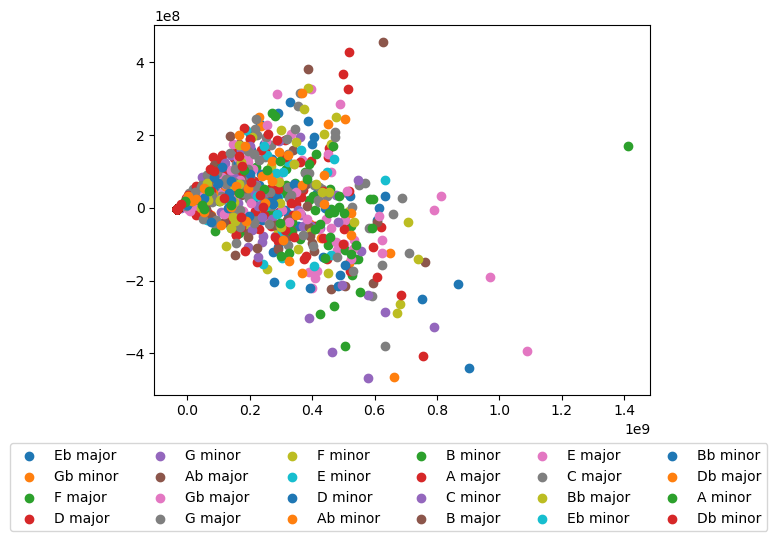

In [3]:
# PCA for initial visualization
pca = PCA(n_components=2)
transformed_data = pca.fit_transform(X_train)

transformed_df = pd.DataFrame(transformed_data, columns=["x", "y"])
transformed_df = transformed_df.join(y_train)

fig = plt.figure()
ax = fig.add_subplot()
for key in all_keys:
  samples = transformed_df[transformed_df["target"] == key]
  ax.scatter(x=samples["x"], y=samples["y"], label=key)
plt.legend(loc='right', bbox_to_anchor=(1.25, -0.25), ncol=6)

### Machine Learning Approach 1:
### Logistic Regression Full Key Classification

In [9]:
log_reg = LogisticRegression()

# Use grid search to find the best regularization for the data
param_grid = {
    'C': [1, 10, 1000, 10000]
}
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

log_reg = LogisticRegression(C=best_params["C"])
log_reg.fit(X_train, y_train)
log_reg_results = log_reg.predict(X_test)

def conf_matrix_to_df(conf_matrix, target_names):
    return pd.DataFrame(conf_matrix, columns=target_names, index=target_names)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=log_reg_results)
conf_matrix_to_df(conf_matrix, all_keys)

c:\Users\Zachary\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Zachary\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_re

,Eb major,Gb minor,F major,D major,G minor,Ab major,Gb major,G major,F minor,E minor,...,C minor,B major,E major,C major,Bb major,Eb minor,Bb minor,Db major,A minor,Db minor
Eb major,98,4,0,0,0,0,0,0,0,0,...,2,2,0,0,0,0,0,0,0,3
Gb minor,2,79,0,3,0,0,0,0,5,0,...,1,3,0,0,0,0,3,1,0,0
F major,0,0,48,4,0,0,0,2,0,0,...,0,0,2,3,0,4,0,0,2,0
D major,0,0,1,42,4,0,0,0,0,0,...,0,1,0,1,0,0,0,0,2,0
G minor,0,0,0,0,76,2,0,0,0,0,...,5,0,0,0,0,0,0,0,6,1
Ab major,2,0,0,0,10,29,0,0,0,0,...,1,8,0,0,0,0,1,0,0,0
Gb major,0,0,0,0,1,0,90,0,0,1,...,0,0,5,0,9,0,0,7,0,0
G major,0,0,0,0,0,0,2,39,0,1,...,0,0,1,0,1,2,0,0,0,0
F minor,0,2,0,0,0,0,0,0,119,2,...,0,0,0,0,8,0,6,3,0,0
E minor,0,0,0,0,0,0,6,1,2,52,...,0,0,7,0,2,1,0,8,0,0


Text(0.5, 1.0, 'Confusion Matrix Heat Map')

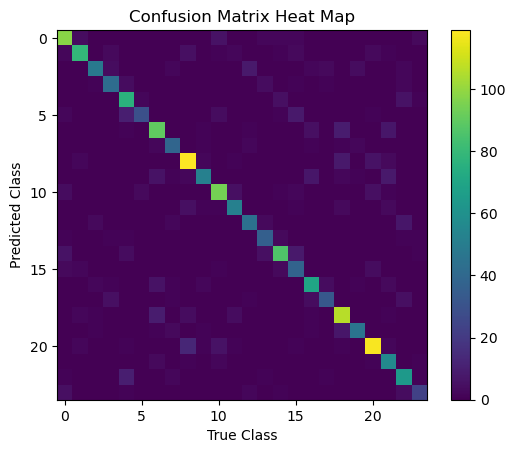

In [10]:
plt.imshow(conf_matrix)
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix Heat Map")

In [11]:
print(classification_report(y_true=y_test, y_pred=log_reg_results))

              precision    recall  f1-score   support

     A major       0.80      0.84      0.82       117
     A minor       0.87      0.79      0.83       100
    Ab major       0.86      0.66      0.74        73
    Ab minor       0.75      0.76      0.76        55
     B major       0.70      0.84      0.77        90
     B minor       0.85      0.53      0.65        55
    Bb major       0.77      0.79      0.78       114
    Bb minor       0.76      0.81      0.79        48
     C major       0.80      0.84      0.82       141
     C minor       0.85      0.66      0.74        79
     D major       0.82      0.82      0.82       115
     D minor       0.80      0.79      0.79        66
    Db major       0.76      0.75      0.75        59
    Db minor       0.71      0.82      0.76        44
     E major       0.83      0.78      0.81       110
     E minor       0.59      0.75      0.66        51
    Eb major       0.77      0.78      0.77        90
    Eb minor       0.79    

### Machine Learning Approach 2:
### Shallow Fully Connected Neural Network

In [4]:
NUM_CLASSES = len(all_keys)
all_keys_int = [i for i, key in enumerate(all_keys)]
KEY_IDS = dict(zip(all_keys, all_keys_int))

# Split the training data into train and validation
xtrain, xval, ytrain, yval = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
xtrain = normalize(xtrain)
xval = normalize(xval)
xtest = normalize(X_test)
ytest = y_test

# Use SMOTE to augment the training data
sm = SMOTE(random_state=42)
xtrain, ytrain = sm.fit_resample(X=xtrain, y=ytrain)

# Convert the labels to integers
ytrain = ytrain.replace(to_replace=KEY_IDS)
yval = yval.replace(to_replace=KEY_IDS)
ytest = ytest.replace(to_replace=KEY_IDS)
# Map the targets to 1-Hot encoding of all 24 classes
ytrain_1hot = to_categorical(ytrain, num_classes=NUM_CLASSES)
yval_1hot = to_categorical(yval, num_classes=NUM_CLASSES)
ytest_1hot = to_categorical(ytest, num_classes=NUM_CLASSES)

print(f'X Train Shape: {xtrain.shape}, Y Train Shape: {ytrain_1hot.shape}')
print(f'X Val Shape: {xval.shape}, Y Val Shape: {yval_1hot.shape}')
print(f'X Test Shape: {xtest.shape}, Y Test Shape: {ytest_1hot.shape}')

X Train Shape: (11808, 5000), Y Train Shape: (11808, 24)
X Val Shape: (1576, 5000), Y Val Shape: (1576, 24)
X Test Shape: (1970, 5000), Y Test Shape: (1970, 24)


In [5]:
l2_reg = 0.0005
def neural_network_train():
    layers = [
        Flatten(),
        Dense(25,
              activation="relu",
              kernel_regularizer=L2(l2_reg)
        ),
        Dense(25,
              activation="relu",
              kernel_regularizer=L2(l2_reg)
        ),
        Dropout(0.1),
        Dense(NUM_CLASSES, activation="softmax")
    ]

    early_stop = EarlyStopping(monitor='val_loss', patience=5)
    model = Sequential(layers)
    opt = optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['acc'])
    history = model.fit(xtrain,
                        ytrain_1hot,
                        batch_size=128,
                        epochs=500,
                        validation_data=(xval, yval_1hot),
                        callbacks=[early_stop])

    return model, history

nn_model, nn_history = neural_network_train()

Epoch 1/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.0501 - loss: 3.2084 - val_acc: 0.0971 - val_loss: 3.1675
Epoch 2/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1051 - loss: 3.1651 - val_acc: 0.1174 - val_loss: 3.1088
Epoch 3/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1218 - loss: 3.1101 - val_acc: 0.1256 - val_loss: 3.0361
Epoch 4/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1343 - loss: 3.0427 - val_acc: 0.1453 - val_loss: 2.9559
Epoch 5/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1579 - loss: 2.9676 - val_acc: 0.1637 - val_loss: 2.8730
Epoch 6/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.1758 - loss: 2.8931 - val_acc: 0.1758 - val_loss: 2.7895
Epoch 7/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.2035 - loss: 2.8093 - val_acc: 0.2024 - val_loss: 2.7082
Epoch 8/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.2274 - loss: 2.7315 - val_acc: 0.2348 - val_loss: 2.6276
Epoch 9/500
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.2455

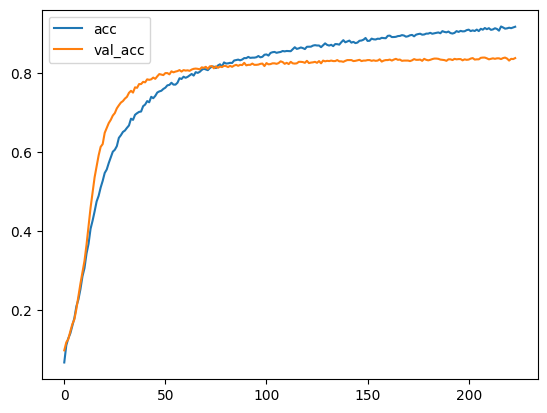

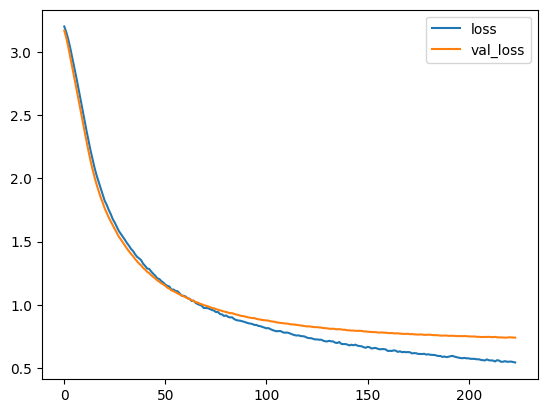

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - acc: 0.8080 - loss: 0.8174
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


Text(0.5, 1.0, 'Confusion Matrix Heat Map')

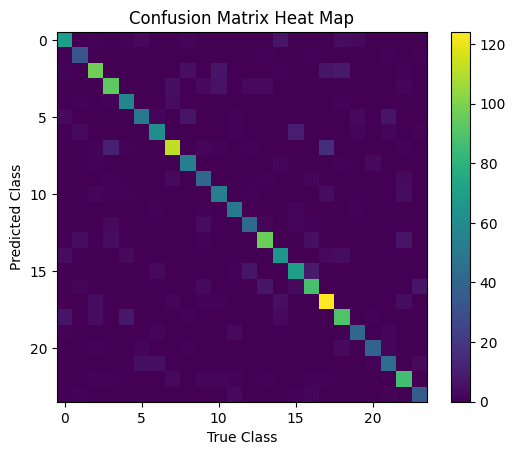

In [6]:
plt.figure(0)
plt.plot(nn_history.history['acc'], label="acc")
plt.plot(nn_history.history['val_acc'], label="val_acc")
plt.legend()
plt.show()

plt.figure(1)
plt.plot(nn_history.history['loss'], label="loss")
plt.plot(nn_history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

nn_model.evaluate(xtest, ytest_1hot)

ypredict = nn_model.predict(xtest)
yclasses = ypredict.argmax(axis=-1)
conf_matrix = confusion_matrix(y_true=ytest, y_pred=yclasses)

plt.figure(2)
plt.imshow(conf_matrix, cmap="viridis")
plt.colorbar(location="right")
plt.xlabel("True Class")
plt.ylabel("Predicted Class")
plt.title("Confusion Matrix Heat Map")

### Machine Learning Approach 3:
### Convolutional Neural Network

In [10]:
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = retrieve_data(square_data=True)

# Split the training data into train and validation
xtrain, xval, ytrain, yval = train_test_split(X_train_cnn, y_train_cnn, test_size=0.2, random_state=42)
xtrain = normalize(xtrain)
xval = normalize(xval)
xtest = normalize(X_test_cnn)
ytest = y_test_cnn

# Use SMOTE to augment the training data
sm = SMOTE(random_state=42)
xtrain, ytrain = sm.fit_resample(X=xtrain, y=ytrain)

# Convert the labels to integers
ytrain = ytrain.replace(to_replace=KEY_IDS)
yval = yval.replace(to_replace=KEY_IDS)
ytest = ytest.replace(to_replace=KEY_IDS)
# Map the targets to 1-Hot encoding of all 24 classes
ytrain_1hot = to_categorical(ytrain, num_classes=NUM_CLASSES)
yval_1hot = to_categorical(yval, num_classes=NUM_CLASSES)
ytest_1hot = to_categorical(ytest, num_classes=NUM_CLASSES)

# Reshape all x sets
xtrain = xtrain.reshape(-1, 70, 70, 1)
xval = xval.reshape(-1, 70, 70, 1)
xtest = xtest.reshape(-1, 70, 70, 1)

print(f'X Train Shape: {xtrain.shape}, Y Train Shape: {ytrain_1hot.shape}')
print(f'X Val Shape: {xval.shape}, Y Val Shape: {yval_1hot.shape}')
print(f'X Test Shape: {xtest.shape}, Y Test Shape: {ytest_1hot.shape}')

X Train Shape: (11808, 70, 70, 1), Y Train Shape: (11808, 24)
X Val Shape: (1576, 70, 70, 1), Y Val Shape: (1576, 24)
X Test Shape: (1970, 70, 70, 1), Y Test Shape: (1970, 24)


In [31]:
# Defining the CNN architecture . . .
model = Sequential([
    Input(shape=(70, 70, 1)),
    Conv2D(32, kernel_size=(12, 12), strides=(2, 2), activation='relu'),
    Conv2D(64, kernel_size=(5, 5), strides=(1, 2), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=2000,
    decay_rate=0.95,
    staircase=True)

optimizer = optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 30, 30, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 26, 13, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 13, 6, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 4992)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1024)           │     5,112,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 24)             │        24,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,193,336 (19.81 MB)

 Trainable params: 5,193,336 (19.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.1429 - loss: 2.8672 - val_accuracy: 0.6764 - val_loss: 0.9623
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.8180 - loss: 0.5799 - val_accuracy: 0.8147 - val_loss: 0.5782
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9120 - loss: 0.2824 - val_accuracy: 0.8357 - val_loss: 0.5355
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.9398 - loss: 0.1806 - val_accuracy: 0.8249 - val_loss: 0.6336
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9676 - loss: 0.1042 - val_accuracy: 0.8490 - val_loss: 0.6330
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9710 - loss: 0.0849 - val_accuracy: 0.8642 - val_loss: 0.6823
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9816 - loss: 0.0523 - val_accuracy: 0.8528 - val_loss: 0.7667
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9815 - loss: 0.0608 - val_accuracy: 0.8363 - v

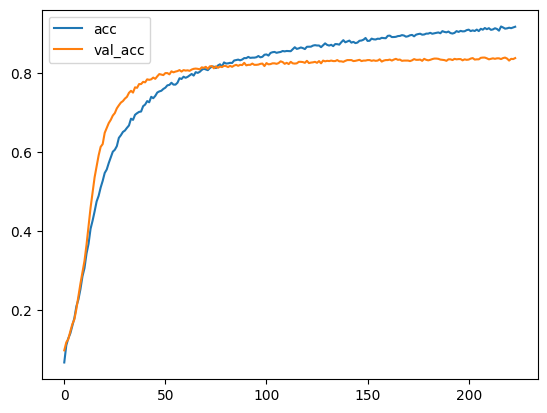

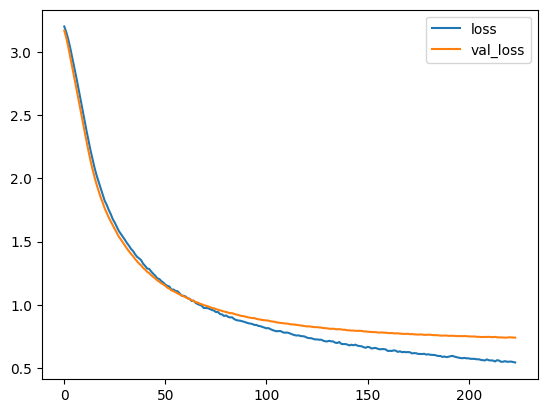

In [32]:
history = model.fit(xtrain, ytrain, validation_data=(xval, yval), epochs=20, batch_size=128)

"""# Evaluate the model
performance = model.evaluate(xval, yval)
print(f'Validation Loss: {performance[0]}, Validation Accuracy: {performance[1]}')"""

plt.figure(0)
plt.plot(nn_history.history['acc'], label="acc")
plt.plot(nn_history.history['val_acc'], label="val_acc")
plt.legend()
plt.show()

plt.figure(1)
plt.plot(nn_history.history['loss'], label="loss")
plt.plot(nn_history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()